# WS 2.6: Be like a Neural Network

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.6. Wednesday December 18, 2024.*

<img src="https://i.pinimg.com/originals/e5/6e/8a/e56e8a055bfbcbeafaf413a70c911876.jpg" width="500" height="400">

Source image: https://www.kaggle.com/code/pranavkasela/neural-networks-from-scratch-code-maths

## Introduction

For several tasks within the domain of Civil Engineering and Geosciences we might be interested in applying machine learning models to understand some physical processes and phenomena which, for many different reasons, are difficult to interpret. Training a machine learning model will typically involves the following steps:

1. Define the model.

2. Define the loss function.

3. Train the model.

4. Evaluate the model.

By using these predefined functions, we can save time and effort when building and training machine learning models.

In this notebook, we start with a very simple dataset with an underlying linear pattern. We then train a simple Multilayer Perceptron (MLP) on it and discuss matters related to model complexity and overfitting. Finally, we move to a more realistic dataset you have already seen before during MUDE.

### Python Environment

You will need the package scikit-learn for this workshop (in addition to a few other typical packages). You can import it to one of your existing conda environments from the conda-forge as (i.e., `
conda install -c conda-forge scikit-learn`), or you can create a new environment from the `*.yml` file included in this repository (`conda env create -f environment    .yml`). But remember: _if you already have sklearn installed in an environment, you don't have to do anything besides use it!_

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Hint:</b>   

We will use boxes with this type of formatting to introduce you to the <code>scikit-learn</code> package and help you with some programming tips.
</p>
</div>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import interpolate
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_formats = ['svg']

## Task 0: Our Data for Today

Machine learning models learn from data and therefore we need data to train our models. For this assignment we will exemplify the use of machine learning in a simple dataset. First, let's create these dummy data. 

<code>data_x</code> represents a general independent variable which has a linear relationship with a target variable $y$. In this case, the ground truth $t$ is:

$$
t = 0.8x+4.75
$$

To make the problem a bit more interesting (and realistic!), we also add Gaussian noise with unit variance to our observations:

$$
t = 0.8x+4.75+\epsilon\quad\quad\epsilon\sim\mathcal{N}(0,1)
$$

Finally, we introduce a _dense validation dataset_ to evaluate our model complexity. Normally you would **split the original dataset** into training and validation sets (as done in PA14), but since our dataset is very small this is not a feasible strategy. For this demonstration we will instead simply evaluate the actual loss through dense integration with a `linspace`:

$$
\mathbb{E}[L]=\displaystyle\int\int\left(t-y(x,\mathbf{w})\right)^2p(x,t)\,dx\,dt
\approx
\displaystyle\frac{1}{N_\mathrm{val}}\sum_{n=1}^{N_\mathrm{val}}\left(t_n-y(x_n)\right)^2
$$

As you can see, this expected loss is based on the squared error, where $t$ is the true value and $y(x)$ is our model.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 0:</b>  

Read the code below, making sure you understand what the data is, as well as the validation set and how it is created. Then execute the cells to visualize the data.
</p>
</div>

In [33]:
# Generate some data
np.random.seed(42)
noise_level = 1.0

data_x = np.array([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]]).transpose()
data_t = 0.8 * data_x + 4.75 + np.random.normal(scale=noise_level,size=data_x.shape)

# Get a very dense validation set to give us the real loss

x_val = np.linspace(np.min(data_x),np.max(data_x),1000)
t_val = 0.8*x_val + 4.75 + np.random.normal(scale=noise_level,size=x_val.shape)
x_val = x_val.reshape(-1,1)

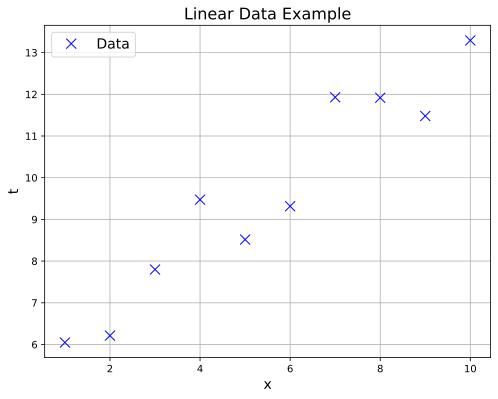

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_x.flatten(), data_t, 'x', color='blue', markersize=10, label='Data')
ax.set_title('Linear Data Example', fontsize=16)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('t', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

## Task 1: Create Your First Neural Network

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1: Implement an MLP</b>   

We now try to fit this data with a Multilayer Perceptron (MLP), also known as a Feedforward Neural Network (FNN), with input, hidden and output layers, each with a specified number of neurons. For such models we also need to specify some hyperparameters. In Scikit-learn, the MLP is defined in the <code>MLPRegressor</code> class, you can see the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).
You should start with a linear MLP, so with `identity` activation and without hidden layers.

</p>
</div>

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Hint:</b>   

You can create the model using the method and two arguments.

Specifying <code>hidden_layer_sizes=()</code> implies that the Neural Network does not have hidden layers. There is only one input layer and one output layer and therefore it is transforming directly $x$ into $y$ without going through intermediate steps.

Specifying <code>activation = 'identity'</code> means that we are not going to alter the output of the model with an activation function such as ReLU, tanh, or sigmoid (the most popular activation functions for Neural Networks).
</p>
</div>

In [35]:
# model = YOUR CODE HERE
# Solution: 
model = MLPRegressor(hidden_layer_sizes=(), activation='identity') 

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2: Train the MLP</b>   

So far the model has not been trained yet. This is something we can do using the <code>partial_fit</code> method and then make predictions with the <code>predict</code> method. Fill in the code below to find the model predictions for the training and validation sets (defined above)
</p>
</div>

In [36]:
n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(data_x, data_t.flatten())

    #MLP_prediction = YOUR CODE HERE
    #MLP_valprediction = YOUR CODE HERE
    # Solution:
    MLP_prediction = model.predict(data_x)
    MLP_valprediction = model.predict(x_val)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(data_t, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val,MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 305.3210, Real loss: 285.3897
Epoch:   1000/10000, MSE: 122.3332, Real loss: 111.9426
Epoch:   2000/10000, MSE: 36.6853, Real loss: 32.0717
Epoch:   3000/10000, MSE: 6.9523, Real loss: 5.4930
Epoch:   4000/10000, MSE: 1.2277, Real loss: 1.1499
Epoch:   5000/10000, MSE: 0.8181, Real loss: 1.1295
Epoch:   6000/10000, MSE: 0.7506, Real loss: 1.1360
Epoch:   7000/10000, MSE: 0.6706, Real loss: 1.1064
Epoch:   8000/10000, MSE: 0.5864, Real loss: 1.0839
Epoch:   9000/10000, MSE: 0.5186, Real loss: 1.0820
Epoch:   9999/10000, MSE: 0.4820, Real loss: 1.1025


<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Hint:</b>   

<b>Be careful about re-running cells!</b> If you executed the cell above more than once, you may have noticed that the values of loss sand MSE stopped changing. Note carefully that in the for loop above we are operating on <code>model</code>, which is an object with type <code>sklearn.neural_network._multilayer_perceptron.MLPRegressor</code>. You can "ask" the model about its status by checking how many epochs have been evaluated with the <code>t_</code> attribute (try it!). If you need to "reset" the model, simply redefine the variable <code>model</code>.
</p>
</div>

Notice how the loss function progressively decreases. That means that our model is indeed learning! That is, it is reducing its error.

Also notice how the `Real loss` value decreases with time. Again remember this is the value of the loss function obtained with a very dense validation dataset. Notice how the training loss is usually lower than the real loss. This is expected, as the training loss is obtained with a very small dataset and is therefore overly optimistic (on average).

Now we can plot the predictions from our model against the data.

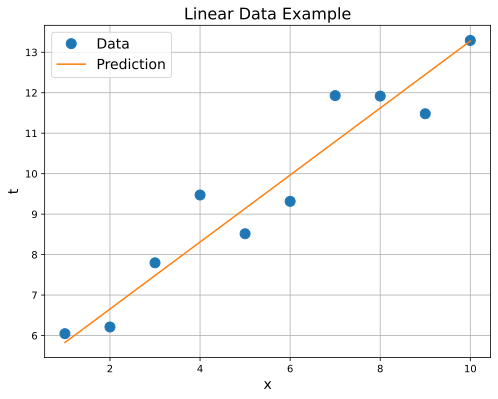

In [37]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_x, data_t, ".", markersize=20, label="Data")
ax.plot(data_x, MLP_prediction, "-", markersize=10, label="Prediction")

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

We can then print the weights of the model. How do they compare to the original slope (0.8) and intercept (4.75)?

In [38]:
print(f'Model coefficients: {model.coefs_}')
print(f'Model intercepts: {model.intercepts_}')

Model coefficients: [array([[0.82771604]])]
Model intercepts: [array([5.00054026])]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3: Increase MLP complexity</b>   

Now let us see if it is a good idea to use a much more flexible model. Initialize and train another MLP, but this time with **two hidden layers with 50 units each** and **tanh** activation.
</p>
</div>

In [39]:
# model = YOUR CODE HERE
# Solution: 
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='tanh') 

n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(data_x, data_t.flatten())

    #MLP_prediction = YOUR CODE HERE
    #MLP_valprediction = YOUR CODE HERE
    # Solution:
    MLP_prediction = model.predict(data_x)
    MLP_valprediction = model.predict(x_val)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(data_t, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val,MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 99.5806, Real loss: 91.2878
Epoch:   1000/10000, MSE: 0.4924, Real loss: 1.2393
Epoch:   2000/10000, MSE: 0.4244, Real loss: 1.1939
Epoch:   3000/10000, MSE: 0.3324, Real loss: 1.2368
Epoch:   4000/10000, MSE: 0.2064, Real loss: 1.2951
Epoch:   5000/10000, MSE: 0.0223, Real loss: 1.5912
Epoch:   6000/10000, MSE: 0.0008, Real loss: 1.7297
Epoch:   7000/10000, MSE: 0.0000, Real loss: 1.6224
Epoch:   8000/10000, MSE: 0.0000, Real loss: 1.6260
Epoch:   9000/10000, MSE: 0.0000, Real loss: 1.6351
Epoch:   9999/10000, MSE: 0.0000, Real loss: 1.6453


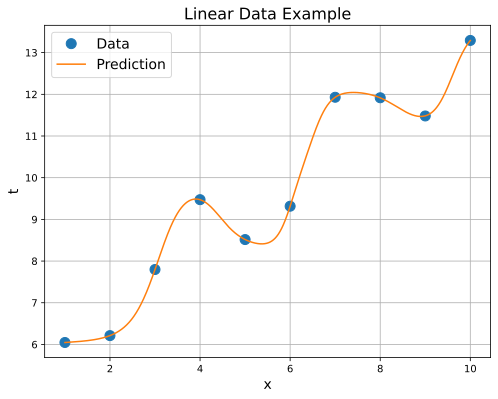

In [40]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_x, data_t, ".", markersize=20, label="Data")
ax.plot(x_val, MLP_valprediction, "-", markersize=10, label="Prediction")

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

What happened to the real loss? Is it higher or lower than before? Is this model good? Think about it: we know the ground truth is actually linear. Would it make sense to have such a flexible model here? Is the validation loss giving you a valuable hint about it?

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.4: Control MLP complexity</b>   

The previous model is way too flexible and we ended up overfitting the noise in the data. So we should use a smaller model, but tweaking the architecture can be annoying. 

For this part you can try something different: **Keep the same network size but add an $L_2$ regularization term** to your model. In `scikit-learn` you can do this by setting the `alpha` parameter you give to `MLPRegressor` to your desired value of $\lambda$. 

Try different values in the interval $0<\lambda\leq1$ and see what happens to model complexity. **What is the value of $\lambda$ that leads to the lowest value for the real loss?**
</p>
</div>

In [41]:
# model = YOUR CODE HERE
# Solution: 
model = MLPRegressor(hidden_layer_sizes=(50,50), activation='tanh',alpha=0.6) 

n_epochs = 10000
N_print = 10**(int(np.log10(n_epochs)) - 1)

for epoch in range(n_epochs):
    model.partial_fit(data_x, data_t.flatten())

    #MLP_prediction = YOUR CODE HERE
    #MLP_valprediction = YOUR CODE HERE
    # Solution:
    MLP_prediction = model.predict(data_x) 
    MLP_valprediction = model.predict(x_val)
    
    if epoch%N_print==0 or epoch==n_epochs-1: 
        print((f'Epoch: {epoch:6d}/{n_epochs}, '
               + f'MSE: {mean_squared_error(data_t, MLP_prediction.reshape(-1,1)):0.4f}, '
               + f'Real loss: {mean_squared_error(t_val,MLP_valprediction):0.4f}'))

Epoch:      0/10000, MSE: 91.7363, Real loss: 83.7890
Epoch:   1000/10000, MSE: 0.5861, Real loss: 1.3480
Epoch:   2000/10000, MSE: 0.5125, Real loss: 1.2702
Epoch:   3000/10000, MSE: 0.4958, Real loss: 1.2472
Epoch:   4000/10000, MSE: 0.4770, Real loss: 1.2152
Epoch:   5000/10000, MSE: 0.4693, Real loss: 1.2040
Epoch:   6000/10000, MSE: 0.4650, Real loss: 1.2018
Epoch:   7000/10000, MSE: 0.4626, Real loss: 1.2011
Epoch:   8000/10000, MSE: 0.4623, Real loss: 1.1999
Epoch:   9000/10000, MSE: 0.4653, Real loss: 1.1974
Epoch:   9999/10000, MSE: 0.4712, Real loss: 1.1925


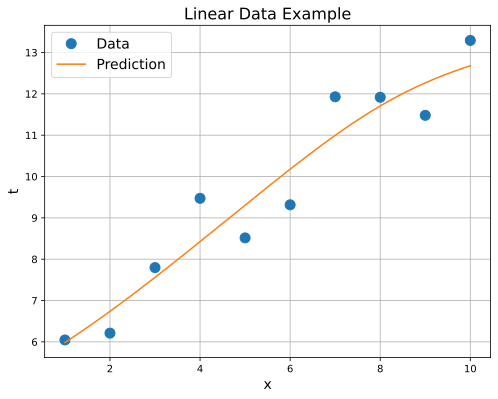

In [42]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data_x, data_t, ".", markersize=20, label="Data")
ax.plot(x_val, MLP_valprediction, "-", markersize=10, label="Prediction")

# Add a title and axis labels
ax.set_title("Linear Data Example", fontsize=16)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a legend
ax.legend(fontsize=14)

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

How close is the model with the lowest validation loss to your first linear model? Is this a reassuring result? 

Neural networks can be very flexible and that is usually a good thing. But at the end of the day you want a model that performs **your specific task** as well as possible, and sometimes that means a very simple linear model is all what you need.

It is nice to see that even if we do not actually know how complex the underlying patterns in our data are, if we have **a good validation dataset** we can rely on it to tell us how flexible our model should be.

## Task 2 - Predict land deformation

For one extra demonstration of how to build neural networks, let's go back to what you did in Week 1.3 - Observation Theory. In Project 2 you were asked to model the deformation of a road caused by the subsidence of the underground by means of GNSS and InSAR data. 

In this workshop you will focus only on the GNSS to making predictions about land deformation. You will be asked to:

- Create a neural network similar to the one you created in the previous tasks
- Change some network parameters and observe how results are affected.

### Task 2.0: Data Processing

First we need to import and convert our data properly:

In [43]:
gnss = pd.read_csv('./data/gnss_observations2.csv')
dates_gnss = pd.to_datetime(gnss['dates'])
gnss_obs = (gnss['observations[m]']).to_numpy() * 1000

def to_days_years(dates):
    '''Convert the observation dates to days and years.'''
    
    dates_datetime = pd.to_datetime(dates)
    time_diff = (dates_datetime - dates_datetime[0])
    days_diff = (time_diff / np.timedelta64(1,'D')).astype(int)
    
    days = days_diff.to_numpy()
    
    return days

days_gnss = to_days_years(dates_gnss)

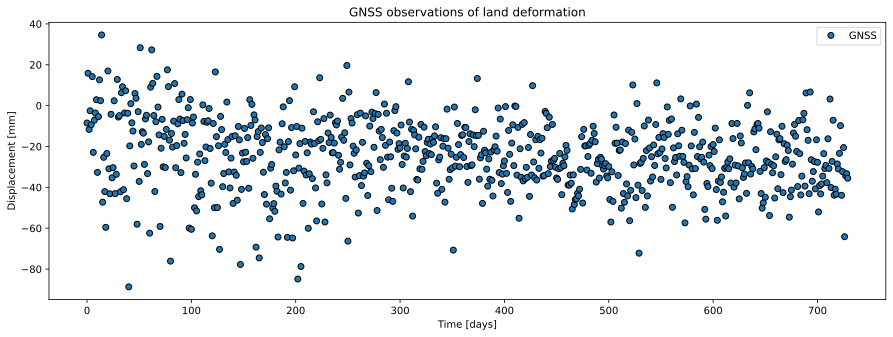

In [44]:
plt.figure(figsize=(15,5))
plt.plot(days_gnss, gnss_obs, 'o', mec='black', label = 'GNSS')
plt.legend()
plt.title('GNSS observations of land deformation')
plt.ylabel('Displacement [mm]')
plt.xlabel('Time [days]')
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1: Split the data</b>  

Define what <code>X</code> and <code>t</code> are. 

Then use the function <code>train_test_split</code> from <code>sklearn.model_selection</code> library to split the initial dataset into a training and validation dataset. Check the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

Use **80%** and **20%** of the data for training and validation, respectively. Also make sure that <code>random_state = 42</code>.
</p>
</div>

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Hint:</b>   

You will need to reshape your arrays in order to first standardize the data and consequently train the model. To do so check [this function](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). The new shape should be <code>(-1,1)</code>. We do this for you ;)
</p>
</div>

In [45]:
X = days_gnss.reshape(-1, 1)
t = gnss_obs.reshape(-1, 1)

In [46]:
# X_train, X_val, t_train, t_val  = YOUR CODE HERE
# Solution:
X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.2, random_state=42)

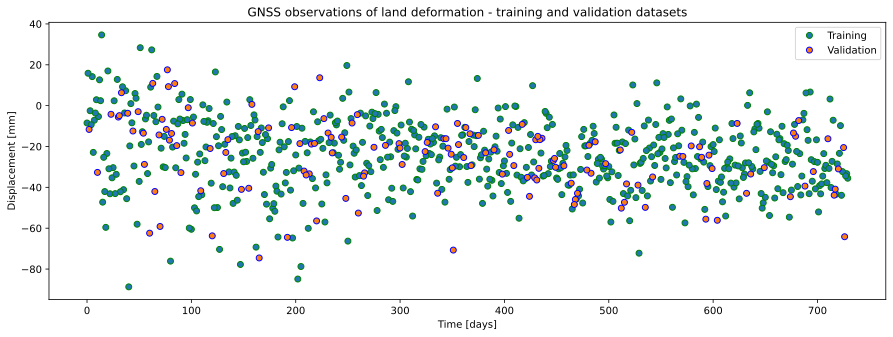

In [47]:
plt.figure(figsize=(15,5))
plt.plot(X_train, t_train, 'o', mec='green', label = 'Training')
plt.plot(X_val, t_val, 'o', mec='blue', label = 'Validation')
plt.title('GNSS observations of land deformation - training and validation datasets')
plt.legend()
plt.ylabel('Displacement [mm]')
plt.xlabel('Time [days]')
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2: Normalize the data</b>  

Before training the model you need to standardize your data. To do so you need <code>StandardScaler</code> from <code>sklearn.preprocessing</code> library. Check the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

Make sure to standardize both <code>X</code> datasets and save them in different arrays. 

Using **a different** `StandardScaler`, normalize the outputs `t_train` and `t_val` as well.
</p>
</div>

<div style="background-color:#C8FFFF; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Hint:</b>   

You first need to standardize just <code>X_train</code> and `t_train`. Only then you can standardize the validation dataset. This will guarantee that the validation data is normalized in the same way as the training data, otherwise the network will get confused when it is time to make predictions. We do this for you ;)
</p>
</div>

In [48]:
input_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)

t_train_scaled = target_scaler.fit_transform(t_train)
t_val_scaled = target_scaler.transform(t_val)

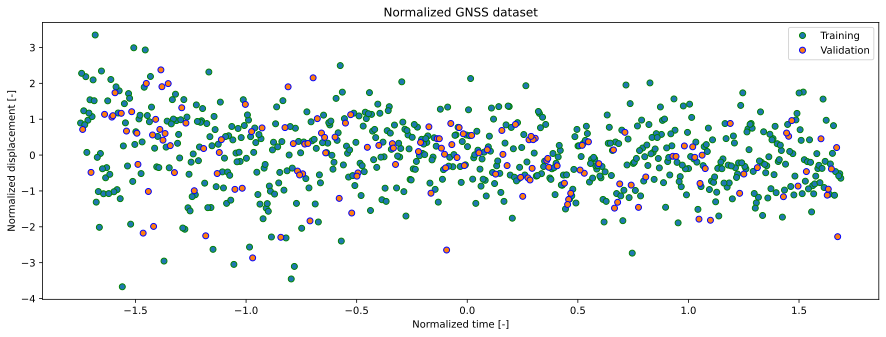

In [49]:
plt.figure(figsize=(15,5))
plt.plot(X_train_scaled, t_train_scaled, 'o', mec='green', label = 'Training')
plt.plot(X_val_scaled, t_val_scaled, 'o', mec='blue', label = 'Validation')
plt.title('Normalized GNSS dataset')
plt.legend()
plt.ylabel('Normalized displacement [-]')
plt.xlabel('Normalized time [-]')
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2B: Check the Figure!</b>  

Look at the figure above and notice how the data has been changed by the normalization process.
</p>
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.3: Create a linear MLP</b>  

As you have done in Task 1 using <code>MLPRegressor</code>, create the Neural Network with no hidden layers and <code>identity</code> activation function. 

In the <code>MLPRegressor</code> you can specify several hyperparameters. Some of the default values are <code>solver='adam'</code> for the optimizer and <code>learning_rate_init=0.001</code> for the initial learning rate $\eta$. For the moment we keep these values fixed, but later you can try to change some of them and see what you get.
</p>
</div>

In [50]:
# model_gnss = YOUR CODE HERE
# Solution:
model_gnss = MLPRegressor(hidden_layer_sizes=(), 
                          activation='identity', random_state=42)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.4: Train the MLP</b>  

Now you can effectively train the model and then test it. In both cases you want to compute the loss and save it.

You are required to do the following:
<ol>
    <li>Initialize the lists for saving the training and validation loss</li>
    <li>Loop over the epochs to train and validate the model. The line <code>model_gnss.partial_fit(X_train_scaled, t_train)</code> is used for training the model in full batch mode. Check the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.partial_fit" target="_blank">Documentation</a> if you're interested.</li>
    <li>For both steps compute the Mean Squared Error (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn-metrics-mean-squared-erro" target="_blank">documentation here</a>) and store it in the lists you previously initialized.</li>
</ol>
</p>
</div>

In [51]:
# train_losses = YOUR CODE HERE
# val_losses = YOUR CODE HERE

# epochs = YOUR CODE HERE

# for epoch in range(YOUR CODE HERE):
#     model_gnss.partial_fit(X_train_scaled, t_train_scaled.flatten())

#     # Calculate training loss
#     train_pred = YOUR CODE HERE
#     train_loss = YOUR CODE HERE
#     train_losses.YOUR CODE HERE

#     # Calculate validation loss
#     val_pred = YOUR CODE HERE
#     val_loss = YOUR CODE HERE
#     val_losses.YOUR CODE HERE

#     # Print losses every 500 epochs
#     if epoch % 500 == 0:
#         print(f'Epoch {epoch}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
# Solution:
train_losses = []
val_losses = []
test_losses = []

epochs = 5000

for epoch in range(1, epochs + 1):
    model_gnss.partial_fit(X_train_scaled, t_train_scaled.flatten())

    # Calculate training loss
    train_pred = model_gnss.predict(X_train_scaled)
    train_loss = mean_squared_error(t_train_scaled, train_pred)
    train_losses.append(train_loss)

    # Calculate validation loss
    val_pred = model_gnss.predict(X_val_scaled)
    val_loss = mean_squared_error(t_val_scaled, val_pred)
    val_losses.append(val_loss)

    # Print losses every 500 epochs
    if epoch % 500 == 0:
        print((f'Epoch {epoch}/{epochs}, '
               + f'Training Loss: {train_loss:.4f}, '
               + f'Validation Loss: {val_loss:.4f}'))

Epoch 500/5000, Training Loss: 1.1580, Validation Loss: 1.1574
Epoch 1000/5000, Training Loss: 0.9796, Validation Loss: 0.9217
Epoch 1500/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 2000/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 2500/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 3000/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 3500/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 4000/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 4500/5000, Training Loss: 0.9789, Validation Loss: 0.9167
Epoch 5000/5000, Training Loss: 0.9789, Validation Loss: 0.9167


Finally you can plot the losses and the predictions made by the network!

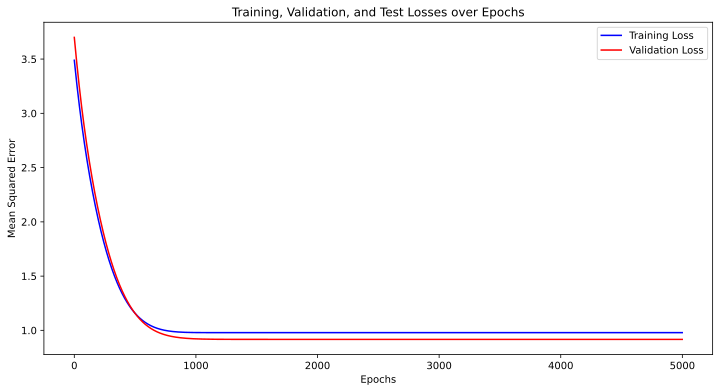

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', c='b')
plt.plot(val_losses, label='Validation Loss', c='r')
plt.title('Training, Validation, and Test Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

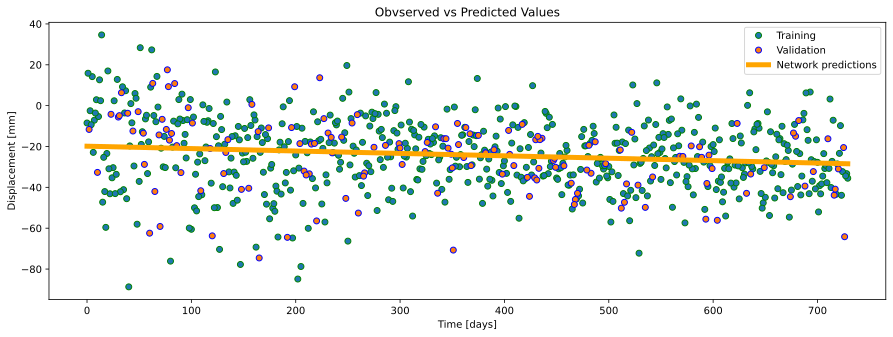

In [53]:
# Plot dataset
plt.figure(figsize=(15,5))
plt.plot(X_train, t_train, 'o', mec='green', label = 'Training')
plt.plot(X_val, t_val, 'o', mec='blue', label = 'Validation')

# Get model predictions for a dense linspace in x
x_plot = np.linspace(np.min(X),np.max(X),1000).reshape(-1,1)
y_plot = model_gnss.predict(input_scaler.transform(x_plot))
plt.plot(x_plot,target_scaler.inverse_transform(y_plot.reshape(-1,1)),color='orange',linewidth=5,label='Network predictions')

plt.title('Obvserved vs Predicted Values')
plt.ylabel('Displacement [mm]')
plt.xlabel('Time [days]')
plt.legend()
plt.show()

Note how we had to **carefully normalize and de-normalize** our data when making new predictions. The network is used to seeing normalized inputs and producing normalized outputs, so we have to:

- Create a `linspace` with the new locations we want to predict at;
- Normalize these inputs with `input_scaler.transform()` so that they fall within the range the network was trained for;
- Call `predict()` to make normalized predictions of $y(x)$;
- Bring the predictions back to the real space with `target_scaler.inverse_transform()` in order to plot them.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.5: Use a more complex network</b>  

Now it is time to make the network a bit more complex. You can change different hyperparameters as we have seen. See [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) for the next tasks.
Go back to the model and do the following:
<ol>
    <li>Add hidden layers to your network</li>
    <li>Change activation functions. Try for instance using ReLU or Tanh</li>
    <li>Try different combinations of activations and network architecture. The ReLU activation tends to work better with deeper networks</li>
    <li>Adjust the strength of the $L_2$ regularization by tweaking the alpha hyperparameter</li>
</ol>

Then run the model again as many times as you deem necessary. Then look at the validation error and use what you have learned before: what is the best model?
</p>
</div>

In [54]:
new_model_gnss = MLPRegressor(hidden_layer_sizes=(20,20,20), activation='relu')

train_losses = []
val_losses = []
test_losses = []

epochs = 5000

for epoch in range(1, epochs + 1):
    new_model_gnss.partial_fit(X_train_scaled, t_train_scaled.flatten())

    # Calculate training loss
    train_pred = new_model_gnss.predict(X_train_scaled)
    train_loss = mean_squared_error(t_train_scaled, train_pred)
    train_losses.append(train_loss)

    # Calculate validation loss
    val_pred = new_model_gnss.predict(X_val_scaled)
    val_loss = mean_squared_error(t_val_scaled, val_pred)
    val_losses.append(val_loss)

    # Print losses every 500 epochs
    if epoch % 500 == 0:
        print(f'Epoch {epoch}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 500/5000 - Training Loss: 0.9335, Validation Loss: 0.8901
Epoch 1000/5000 - Training Loss: 0.9317, Validation Loss: 0.8889
Epoch 1500/5000 - Training Loss: 0.9300, Validation Loss: 0.8887
Epoch 2000/5000 - Training Loss: 0.9286, Validation Loss: 0.8869
Epoch 2500/5000 - Training Loss: 0.9274, Validation Loss: 0.8842
Epoch 3000/5000 - Training Loss: 0.9255, Validation Loss: 0.8897
Epoch 3500/5000 - Training Loss: 0.9238, Validation Loss: 0.8891
Epoch 4000/5000 - Training Loss: 0.9224, Validation Loss: 0.8838
Epoch 4500/5000 - Training Loss: 0.9211, Validation Loss: 0.8828
Epoch 5000/5000 - Training Loss: 0.9204, Validation Loss: 0.8863


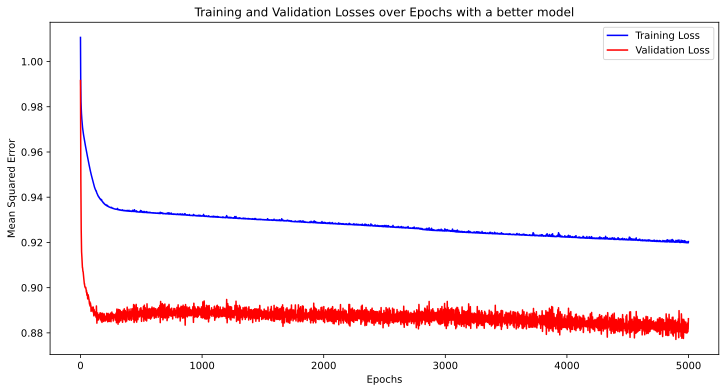

In [55]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', c='b')
plt.plot(val_losses, label='Validation Loss', c='r')
plt.title('Training and Validation Losses over Epochs with a better model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

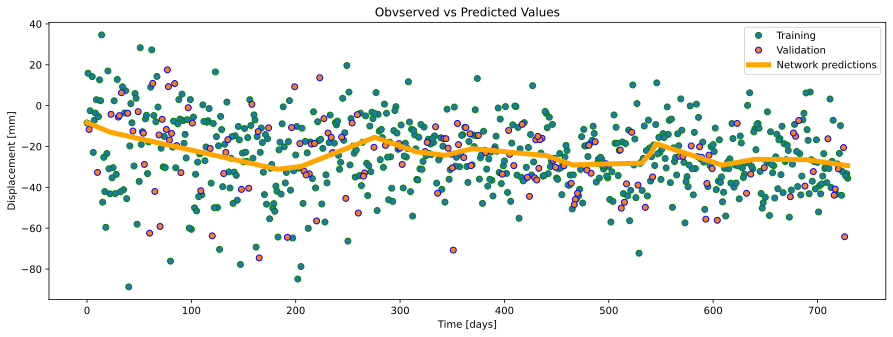

In [56]:
# Plot dataset
plt.figure(figsize=(15,5))
plt.plot(X_train, t_train, 'o', mec='green', label = 'Training')
plt.plot(X_val, t_val, 'o', mec='blue', label = 'Validation')

# Get model predictions for a dense linspace in x
x_plot = np.linspace(np.min(X),np.max(X),1000).reshape(-1,1)
y_plot = new_model_gnss.predict(input_scaler.transform(x_plot))
plt.plot(x_plot,target_scaler.inverse_transform(y_plot.reshape(-1,1)),color='orange',linewidth=5,label='Network predictions')

plt.title('Obvserved vs Predicted Values')
plt.ylabel('Displacement [mm]')
plt.xlabel('Time [days]')
plt.legend()
plt.show()

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b>   
Note that the example shown above in this document is not the <b>best</b> solution! It was simply the last one we tried (you were supposed to experiment with several combinations). This looks like a case of overfitting, which you can also see in the validation plot above (the final epoch is not the minimum validation loss).

</p>
</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.